In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
model = load_model("model/lstm_volatility_model.keras")
scaler = joblib.load("model/scaler.save")

C:\Users\vicen\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
def get_binance_data(asset="ETHUSDT", timeframe="1h", limit=1000):
    import requests
    import pandas as pd

    url = 'https://api.binance.com/api/v3/klines'
    params = {'symbol': asset, 'interval': timeframe, 'limit': limit}

    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"❌ Erreur API Binance ({response.status_code}): {response.text}")
        return pd.DataFrame()

    df = pd.DataFrame(response.json(), columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'trades',
        'taker_base_volume', 'taker_quote_volume', 'ignore'
    ])
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    df.set_index('timestamp', inplace=True)
    return df


In [4]:
def preprocess_live(df):
    from arch import arch_model
    from hurst import compute_Hc

    # Log-return
    df['log_return'] = np.log(df['close'] / df['close'].shift(1)) * 100
    df['volatility'] = df['log_return'].rolling(window=30).std() * np.sqrt(365)

    # Vérification taille log_return
    log_ret_clean = df['log_return'].dropna()
    if len(log_ret_clean) < 60:
        raise ValueError("❌ Pas assez de données pour calculer un GARCH")

    # GARCH
    am = arch_model(log_ret_clean, vol='Garch', p=1, q=1)
    res = am.fit(disp='off')
    df.loc[df.index[1:], 'garch_vol'] = res.conditional_volatility

    # Hurst exponent
    if df['volatility'].dropna().shape[0] < 100:
        df['hurst'] = 0.5  # Valeur neutre
    else:
        H, _, _ = compute_Hc(df['volatility'].dropna(), kind='price', simplified=True)
        df['hurst'] = H

    return df.dropna()



In [5]:
def predict_spike_live(model, scaler, df_input, seq_length=50):
    features = ['volatility', 'garch_vol', 'hurst']

    # Vérification des colonnes
    if not all(f in df_input.columns for f in features):
        raise ValueError(" Les colonnes nécessaires ne sont pas toutes présentes dans les données.")

    # Extraction des features et normalisation
    X_live = df_input[features].tail(seq_length).values
    X_scaled = scaler.transform(X_live)

    # Mise en forme pour le modèle LSTM
    X_seq = np.expand_dims(X_scaled, axis=0)  # Shape: (1, 50, 3)

    # Prédiction
    prediction = model.predict(X_seq)[0][0]
    signal = "🔴 Spike probable" if prediction > 0.5 else "🟢 Calme"

    print(f"{signal} — Probabilité prédite : {prediction:.4f}")
    return prediction



In [26]:
def plot_volatility(df, symbol="BTC-USD"):
    plt.figure(figsize=(12, 5))
    plt.plot(df.index[-60:], df['volatility'].tail(60), label='Volatility')

    # Calcul du seuil sécurisé
    rolling_mean = df['volatility'].rolling(30).mean()
    seuil = rolling_mean.iloc[-1]*1.08

    plt.axhline(y= seuil, color='r', linestyle='--', label='Seuil Spike')
    plt.title(f"Volatilité journalière de {symbol} sur les 60 derniers jours")
    plt.xlabel("Date")
    plt.ylabel("Volatilité annualisée")
    plt.legend()
    plt.grid(True)
    plt.show()



C:\Users\vicen\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
🟢 Calme — Probabilité prédite : 0.0015


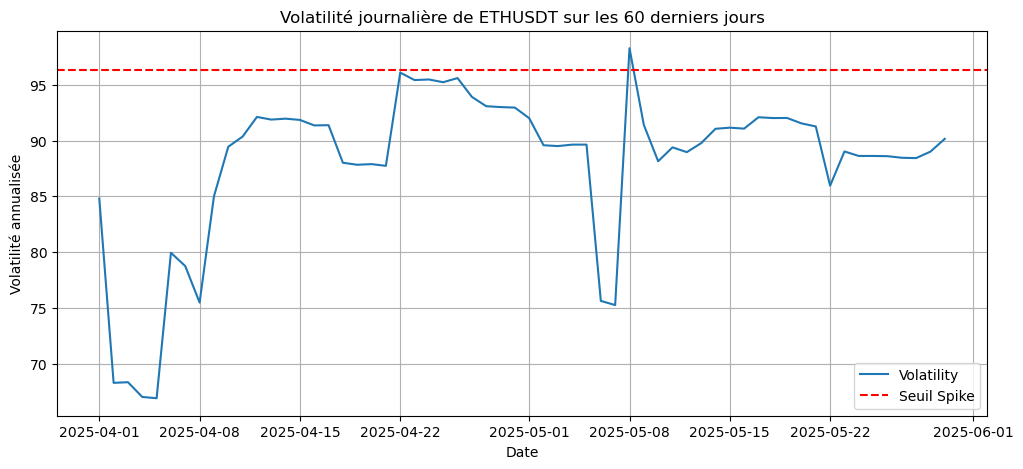

In [29]:
df_raw = get_binance_data(asset="ETHUSDT", timeframe="1d", limit=500)
df_processed = preprocess_live(df_raw)
prediction = predict_spike_live(model, scaler, df_processed)
visu = plot_volatility(df_raw, symbol="ETHUSDT")


### Comment nous pouvons le voir, le pic de volatilité a bien été anticipé par mon modèle